In [2]:
import numpy as np
import torch, torch.nn as nn
import snntorch as snn
from snntorch import surrogate, utils, backprop
import snntorch.functional as SF
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime



In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_indices = list(range(len(training_set)))
np.random.shuffle(train_indices)
train_sampler = SubsetRandomSampler(train_indices[:5000])

val_indices = list(range(len(validation_set)))
np.random.shuffle(val_indices)
val_sampler = SubsetRandomSampler(val_indices[:1000])

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, sampler=val_sampler)

tensor([0, 6, 6, 5])


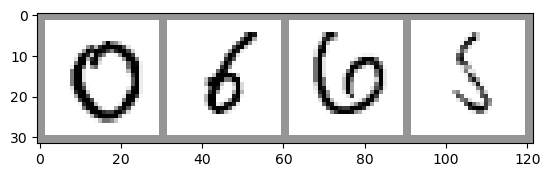

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print(labels)

In [4]:
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
loss_fn = nn.CrossEntropyLoss()

In [5]:
torch.manual_seed(0)
basic_model = BasicModel().to(device)
optimizer = torch.optim.Adam(basic_model.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [6]:
# x = torch.tensor(np.random.rand(100,28,28), dtype=dtype)
# y = torch.ones([100, 10])

In [7]:
# loss_hist = []
# for epoch in range(100):
#     iter_counter = 0

#     # forward pass
#     basic_model.train()
#     spk_rec, mem_rec = basic_model(x)

#     loss_val = torch.zeros((1), dtype=dtype, device=device)
#     for step in range(100):
#         loss_val += loss_fn(mem_rec[step], y)

#     # Gradient calculation + weight update
#     optimizer.zero_grad()
#     loss_val.backward()
#     optimizer.step()

#     loss_hist.append(loss_val.item())

In [8]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # forward pass
        basic_model.train()
        spk_rec, mem_rec = basic_model(inputs)

        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(25):
            loss_val += loss_fn(mem_rec[step], labels)        

        # Zero your gradients for every batch!
        optimizer.zero_grad()
        loss_val.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss_val.item()
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            print(f'  batch {i + 1} loss: {last_loss}')
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [9]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'runs/fashion_trainer_{timestamp}')
epoch_number = 0

EPOCHS = 1

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    basic_model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    basic_model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        spk_rec, mem_rec = basic_model(vinputs)
        vloss = torch.zeros((1), dtype=dtype, device=device)
        for step in range(25):
            vloss += loss_fn(mem_rec[step], labels)  
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(basic_model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 100 loss: 58.69397712707519
  batch 200 loss: 58.71328857421875
  batch 300 loss: 58.44194541931152
  batch 400 loss: 59.31764968872071
  batch 500 loss: 58.43505596160889
  batch 600 loss: 58.14370433807373
  batch 700 loss: 58.208292198181155
  batch 800 loss: 57.54457901000976
  batch 900 loss: 57.59623413085937
  batch 1000 loss: 57.57421119689941
  batch 1100 loss: 57.57990997314453
  batch 1200 loss: 57.52271625518799
LOSS train 57.52271625518799 valid tensor([58.4092], grad_fn=<DivBackward0>)


In [10]:
batch_data = next(iter(training_loader))
inputs, labels = batch_data

output, _ = basic_model(inputs)
_, idx = output.sum(dim=0).max(1)
acc = np.mean((labels == idx).detach().cpu().numpy())
acc

0.0

In [11]:
output

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0

In [2]:
from mnn_torch.devices import load_SiOx_multistate

In [2]:
import torch
x = torch.rand(5, 3)
print(x)

torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
torch.cuda.get_device_name(0)

tensor([[0.2656, 0.6610, 0.9424],
        [0.6912, 0.2038, 0.6678],
        [0.9582, 0.2312, 0.0995],
        [0.6485, 0.9269, 0.7110],
        [0.7278, 0.5288, 0.1134]])


'NVIDIA GeForce RTX 4090'